## Imports

In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
import matplotlib.pyplot as plt
import os
import random

## GRU RNN - Pranav

## LSTM - Teresa

In [4]:
movieRev = pd.read_csv("IMDB Dataset.csv")
movieRev

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
# Equal amounts, so there is no need to normalize
movieRev['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

### Preprocessing

In [6]:
# Find the review with the highest number of words
def maxWords(reviewList):
    words = 5000        # Arbitrary value for max words
    for review in reviewList:
        if (len(review.split()) > words):
            words = len(review.split())
            
    return words

In [8]:
reviewList = movieRev['review'].tolist()
words = maxWords(reviewList)
print(words)

5000


In [9]:
# Convert categorical values to numeric using factorize()
sentiment_label = movieRev['sentiment'].factorize()
print(sentiment_label[0])

[0 0 0 ... 1 1 1]


In [12]:
text = movieRev['review'].values

# Tokenize the words in text and fit to associate the words and labels
tokenizer = Tokenizer(num_words=words)
tokenizer.fit_on_texts(text)

# Identify the size of vocabulary
vocab_size = len(tokenizer.word_index) + 1

# Replace words with their assigned numbers using text_to_sequence()
encoding = tokenizer.texts_to_sequences(text)

# Add padding so sentences can have equal length
pad_sequence = pad_sequences(encoding, maxlen=200)

### LSTM Classifier

In [14]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 32)           3976096   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 128)               82432     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,058,657
Trainable params: 4,058,657
Non-trainable params: 0
____________________________________________

### Train Model

**[CAUTION]** May take over 30 minutes to run. <br>
Base Model: 5 epochs, batch_size=32, validation_split=0.2

In [15]:
# Train for 5 epochs with batch size 32 and validation split 20%
history = model.fit(pad_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
1250/1250 [==============================] - 338s 269ms/step - loss: 0.4313 - accuracy: 0.7968 - val_loss: 0.3595 - val_accuracy: 0.8388
Epoch 2/5
1250/1250 [==============================] - 358s 286ms/step - loss: 0.3044 - accuracy: 0.8758 - val_loss: 0.3375 - val_accuracy: 0.8548
Epoch 3/5
1250/1250 [==============================] - 359s 288ms/step - loss: 0.2751 - accuracy: 0.8914 - val_loss: 0.2921 - val_accuracy: 0.8827
Epoch 4/5
1250/1250 [==============================] - 348s 279ms/step - loss: 0.2532 - accuracy: 0.8988 - val_loss: 0.2827 - val_accuracy: 0.8812
Epoch 5/5
1250/1250 [==============================] - 381s 305ms/step - loss: 0.2439 - accuracy: 0.9042 - val_loss: 0.2936 - val_accuracy: 0.8817


### Results

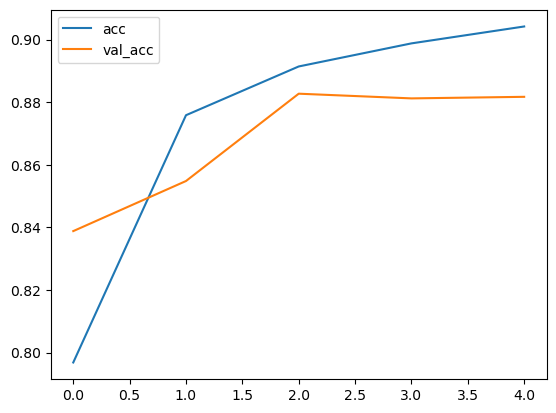

In [18]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

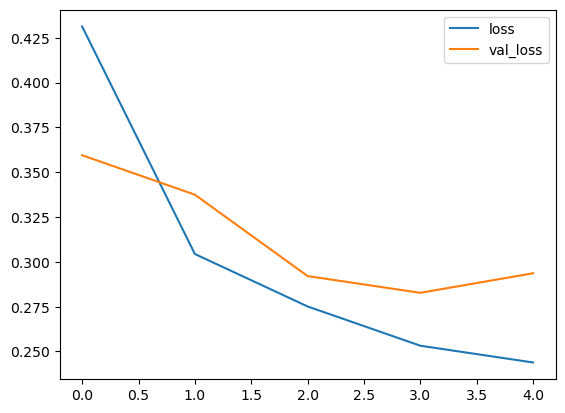

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### Predict using Model

In [20]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
#     print("Predicted label: ", sentiment_label[1][prediction])
    return sentiment_label[1][prediction]

test_sentence1 = "I enjoyed this movie. The actors were very inspirational."
print(predict_sentiment(test_sentence1))

test_sentence2 = "This is the worst movie I've ever seen in my life!"
print(predict_sentiment(test_sentence2))

1/1 [==============================] - 0s 358ms/step
positive
1/1 [==============================] - 0s 45ms/step
negative


In [22]:
# Check Positive and Negative Testing Examples
print("Number of Positive Examples:", len(os.listdir("teresa_pham/aclImdb/test/pos/")))
print("Number of Negative Examples:", len(os.listdir("teresa_pham/aclImdb/test/neg/")))

Number of Positive Examples: 12500
Number of Negative Examples: 12500


In [24]:
# Predict all files' content in the test directory (first 500 examples)
def predict_all(fileList, predict):
    count = 0
    total = 0
    if predict == "positive":
        cur_dir = os.getcwd() + "/teresa_pham//aclImdb/test/pos/"
    else:
        cur_dir = os.getcwd() + "/teresa_pham/aclImdb/test/neg/"
        
    for file in fileList:
        f = open(cur_dir+ file, "r")
        val = predict_sentiment(f.read())
        if val==predict:
            count += 1
        total += 1
        
    return float(count/total)
        
pos_examples = os.listdir("teresa_pham/aclImdb/test/pos/")[:1000]
neg_examples = os.listdir("teresa_pham/aclImdb/test/neg/")[:1000]
predict_pos = predict_all(pos_examples, "positive")
predict_neg = predict_all(neg_examples, "negative")

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


In [25]:
print("Predict Positive Accuracy:", predict_pos)
print("Predict Negative Accuracy:", predict_neg)

Predict Positive Accuracy: 0.948
Predict Negative Accuracy: 0.892


In [32]:
# Predict all files' content in the test directory (first 500 examples)
def predict_all_mixed(fileList, predictList):
    count = 0
    total = 0

    for file in fileList:
        if predictList[total] == "positive":
            cur_dir = os.getcwd() + "/teresa_pham/aclImdb/test/pos/"
        else:
            cur_dir = os.getcwd() + "/teresa_pham/aclImdb/test/neg/"

        f = open(cur_dir+ file, "r")
        val = predict_sentiment(f.read())
        if val==predictList[total]:
            count += 1
        total += 1
        
    return float(count/total)

In [ ]:
mix_examples = os.listdir("teresa_pham/aclImdb/test/pos/")[1000:2000] + os.listdir("teresa_pham/aclImdb/test/neg/")[2000:3000]
pos = ["positive" for i in range(1000)]
neg = ["negative" for j in range(1000)]
mix_list = pos + neg

# Randomize the examples
temp = list(zip(mix_examples, mix_list))
random.shuffle(temp)
mixEx, mixList = zip(*temp)
mixEx, mixList = list(mixEx), list(mixList)

predict_mix = predict_all_mixed(mixEx, mixList)

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 51ms/step


In [ ]:
print("Mixed List Accuracy:", predict_mix)

## Transformer-based Model - Tri